In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [2]:
fl_inflow_origin_2122 = pd.read_excel("2122fl.xlsx", sheet_name="County Inflow", usecols="C:F", skiprows=5)
fl_inflow_origin_2122.columns = ["state_code", "county_code", "state", "county_name"]

fl_inflow_counts_2122 = pd.read_excel("2122fl.xlsx", sheet_name="County Inflow", usecols="G:I", skiprows=5)
fl_inflow_counts_2122.columns = ["number_of_returns", "number_of_individuals", "AGI"]

In [3]:
fl_inflow_origin_1718 = pd.read_excel("1718fl.xls", sheet_name="County Inflow", usecols="C:F", skiprows=5)
fl_inflow_origin_1718.columns = ["state_code", "county_code", "state", "county_name"]

fl_inflow_counts_1718 = pd.read_excel("1718fl.xls", sheet_name="County Inflow", usecols="G:I", skiprows=5)
fl_inflow_counts_1718.columns = ["number_of_returns", "number_of_individuals", "AGI"]

In [5]:
fl_inflow_2122 = pd.concat([fl_inflow_origin_2122, fl_inflow_counts_2122], axis=1)
fl_inflow_1718 = pd.concat([fl_inflow_origin_1718, fl_inflow_counts_1718], axis=1)
fl_inflow_2122.dropna(inplace= True)
fl_inflow_1718.dropna(inplace= True)

In [6]:
def prepare_migration_data(df, total_label="Total Migration-US", non_label="Non-migrants"):
    # Total US migration
    total_us = df[df["county_name"].str.endswith(total_label)].copy()
    total_us["county_name"] = total_us["county_name"].str.extract(r"^(.+?) County")[0]
    total_us = total_us[["county_name", "number_of_individuals"]].rename(
        columns={"number_of_individuals": "total_migration"}
    )
    
    # Non-migrants
    non = df[df["county_name"].str.contains(non_label, case=False, na=False)].copy()
    non["county_name"] = non["county_name"].str.extract(r"^(.+?) County")[0]
    non = non[["county_name", "county_code", "number_of_individuals"]].rename(
        columns={"number_of_individuals": "non_migrants"}
    )
    
    # Merge
    final_df = pd.merge(non, total_us, on="county_name", how="inner")
    
    return final_df[["county_name", "county_code", "total_migration", "non_migrants"]]


In [16]:
df_1718 = prepare_migration_data(fl_inflow_1718)
df_2122 = prepare_migration_data(fl_inflow_2122)

df_1718.rename(columns={
    "total_migration": "total_migration_1718",
    "non_migrants": "non_migrants_1718"
}, inplace=True)

df_2122.rename(columns={
    "total_migration": "total_migration_2122",
    "non_migrants": "non_migrants_2122"
}, inplace=True)


In [ ]:
cdc_data_22 = pd.read_csv('500_cities_data_22.csv')
cdc_data_18 = pd.read_csv('500_cities_data_18.csv')

cdc_fl_22 = cdc_data_22[cdc_data_22["StateDesc"].str.contains("Florida", case=False, na=False)].copy()
cdc_fl_18 = cdc_data_18[cdc_data_18["StateDesc"].str.contains("Florida", case=False, na=False)].copy()

mental_health_18 = cdc_fl_18.groupby("CountyName")["MHLTH_CrudePrev"].mean().reset_index()
mental_health_18.rename(columns={"MHLTH_CrudePrev": "mental_health_18"}, inplace=True)

mental_health_22 = cdc_fl_22.groupby("CountyName")["MHLTH_CrudePrev"].mean().reset_index()
mental_health_22.rename(columns={"MHLTH_CrudePrev": "mental_health_22"}, inplace=True)


  CountyName  mental_health_18
0    Alachua         16.505357
1      Baker         17.200000
2        Bay         16.893023
3   Bradford         17.900000
4    Brevard         14.757658
  CountyName  mental_health_22
0    Alachua         19.410345
1      Baker         19.450000
2        Bay         18.302041
3   Bradford         19.233333
4    Brevard         15.899306


In [20]:
merged_df_1718 = pd.merge(df_1718, mental_health_18, left_on="county_name", right_on="CountyName", how="inner")
merged_df_1718.drop(columns=["CountyName"], inplace=True)

merged_df_2122 = pd.merge(df_2122, mental_health_22, left_on="county_name", right_on="CountyName", how="inner")
merged_df_2122.drop(columns=["CountyName"], inplace=True)

merged_all_years = pd.merge(
    merged_df_1718, 
    merged_df_2122, 
    on=["county_name", "county_code"], 
    how="outer"
)

In [24]:
merged_all_years.columns

Index(['county_name', 'county_code', 'total_migration_1718',
       'non_migrants_1718', 'mental_health_18', 'total_migration_2122',
       'non_migrants_2122', 'mental_health_22'],
      dtype='object')

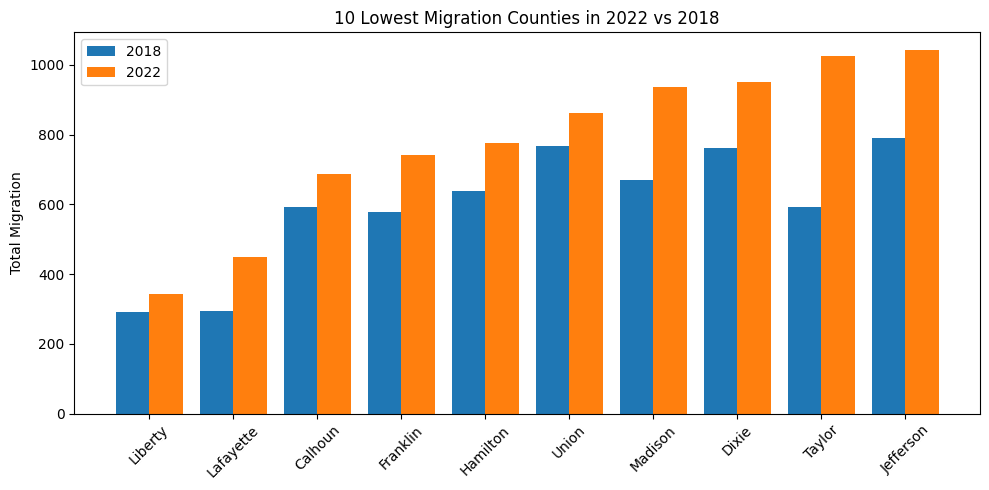

In [ ]:
for col in ["total_migration_1718", "total_migration_2122"]:
    merged_all_years[col] = pd.to_numeric(merged_all_years[col], errors="coerce")

# Pick 10 counties with lowest migration in 2022
lowest_2022 = merged_all_years.nsmallest(10, "total_migration_2122")

x = range(len(lowest_2022))
plt.figure(figsize=(10,5))
plt.bar(x, lowest_2022["total_migration_1718"], width=0.4, label="2018")
plt.bar([i+0.4 for i in x], lowest_2022["total_migration_2122"], width=0.4, label="2022")
plt.xticks([i+0.2 for i in x], lowest_2022["county_name"], rotation=45)
plt.ylabel("Total Migration")
plt.title("10 Lowest Migration Counties in 2022 vs 2018")
plt.legend()
plt.tight_layout()
plt.show()


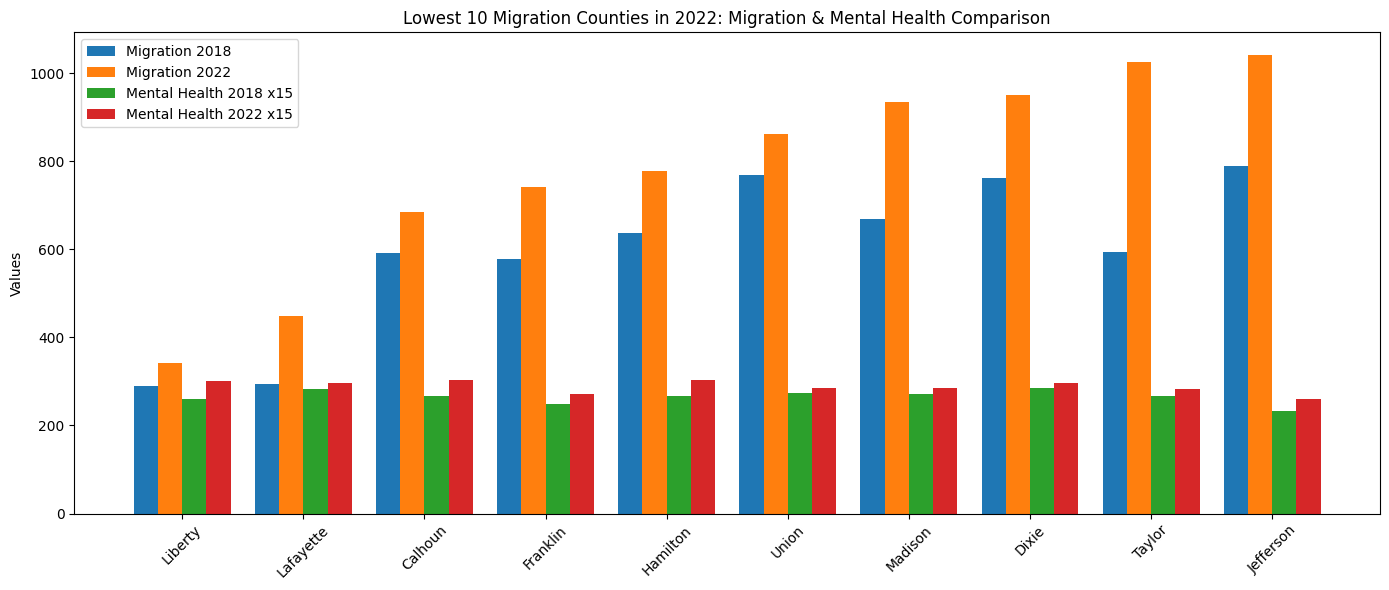

In [33]:
import matplotlib.pyplot as plt
import numpy as np

# Pick 10 lowest migration counties in 2022
lowest_2022 = merged_all_years.nsmallest(10, "total_migration_2122")

counties = lowest_2022["county_name"]
x = np.arange(len(counties))
width = 0.2  

# Scale mental health for visualization
scale_factor = 15  # adjust so bars are visible compared to migration
mh_18_scaled = lowest_2022["mental_health_18"] * scale_factor
mh_22_scaled = lowest_2022["mental_health_22"] * scale_factor

fig, ax = plt.subplots(figsize=(14,6))

# Bars
ax.bar(x - 1.5*width, lowest_2022["total_migration_1718"], width, label="Migration 2018", color="#1f77b4")
ax.bar(x - 0.5*width, lowest_2022["total_migration_2122"], width, label="Migration 2022", color="#ff7f0e")
ax.bar(x + 0.5*width, mh_18_scaled, width, label=f"Mental Health 2018 x{scale_factor}", color="#2ca02c")
ax.bar(x + 1.5*width, mh_22_scaled, width, label=f"Mental Health 2022 x{scale_factor}", color="#d62728")

# Labels and title
ax.set_xticks(x)
ax.set_xticklabels(counties, rotation=45)
ax.set_ylabel("Values")
ax.set_title("Lowest 10 Migration Counties in 2022: Migration & Mental Health Comparison")
ax.legend()

plt.tight_layout()
plt.show()


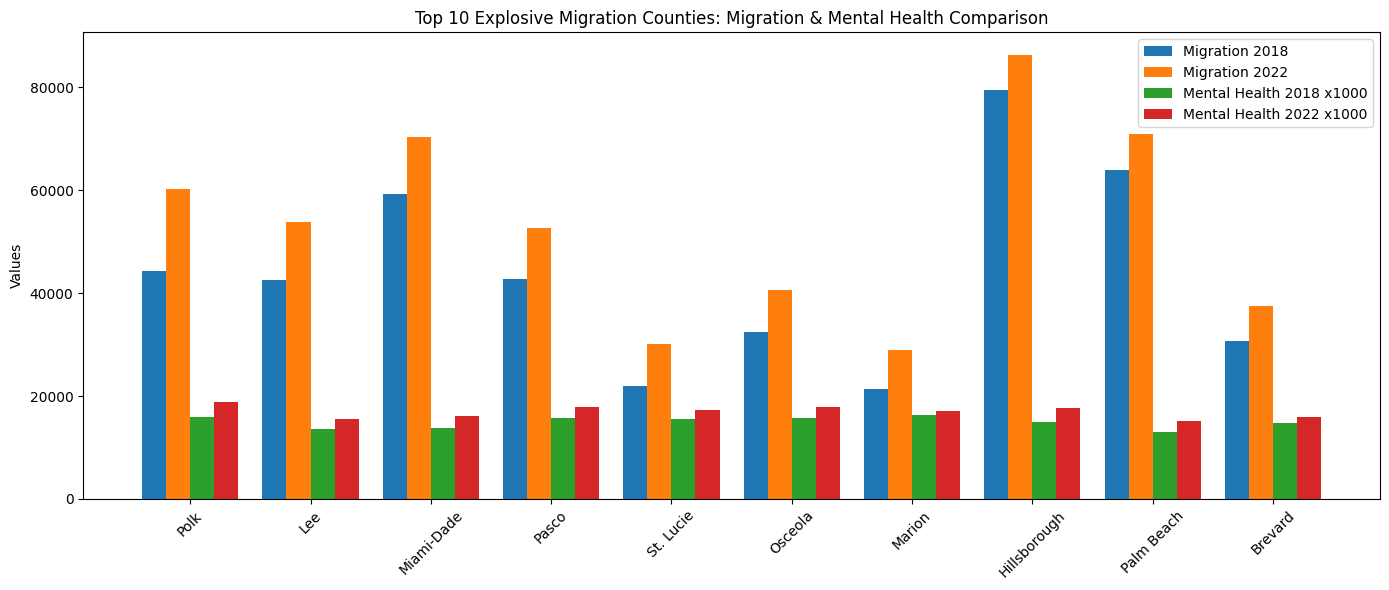

In [ ]:
# See explosive migration

merged_all_years["migration_diff"] = merged_all_years["total_migration_2122"] - merged_all_years["total_migration_1718"]

top10 = merged_all_years.nlargest(10, "migration_diff")

counties = top10["county_name"]
x = np.arange(len(counties))
width = 0.2

scale_factor = 1000
mh_18_scaled = top10["mental_health_18"] * scale_factor
mh_22_scaled = top10["mental_health_22"] * scale_factor

fig, ax = plt.subplots(figsize=(14,6))

ax.bar(x - 1.5*width, top10["total_migration_1718"], width, label="Migration 2018", color="#1f77b4")
ax.bar(x - 0.5*width, top10["total_migration_2122"], width, label="Migration 2022", color="#ff7f0e")
ax.bar(x + 0.5*width, mh_18_scaled, width, label=f"Mental Health 2018 x{scale_factor}", color="#2ca02c")
ax.bar(x + 1.5*width, mh_22_scaled, width, label=f"Mental Health 2022 x{scale_factor}", color="#d62728")

ax.set_xticks(x)
ax.set_xticklabels(counties, rotation=45)
ax.set_ylabel("Values")
ax.set_title("Top 10 Explosive Migration Counties: Migration & Mental Health Comparison")
ax.legend()

plt.tight_layout()
plt.show()


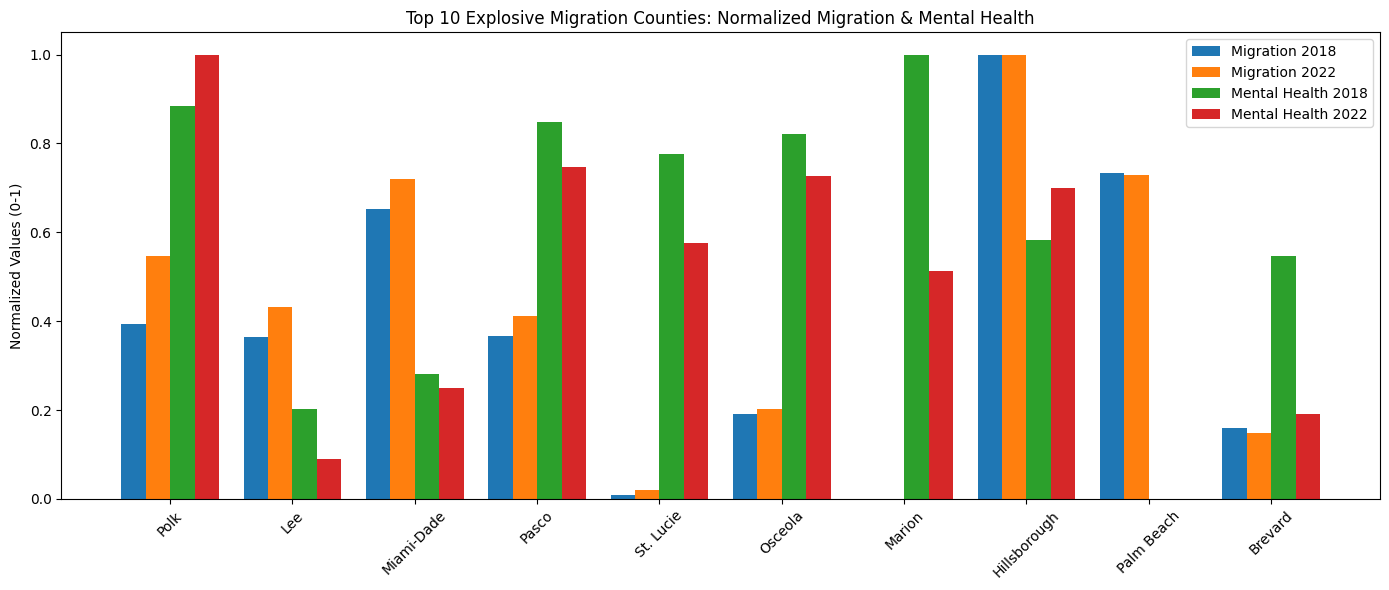

In [ ]:
# scaling it to 0-1

merged_all_years["migration_diff"] = merged_all_years["total_migration_2122"] - merged_all_years["total_migration_1718"]

top10 = merged_all_years.nlargest(10, "migration_diff")

# Min-max scaling function
def min_max_scale(series):
    return (series - series.min()) / (series.max() - series.min())

# Normalize all 4 columns
migration_1718_scaled = min_max_scale(top10["total_migration_1718"])
migration_2122_scaled = min_max_scale(top10["total_migration_2122"])
mh_18_scaled = min_max_scale(top10["mental_health_18"])
mh_22_scaled = min_max_scale(top10["mental_health_22"])

counties = top10["county_name"]
x = np.arange(len(counties))
width = 0.2

fig, ax = plt.subplots(figsize=(14,6))

ax.bar(x - 1.5*width, migration_1718_scaled, width, label="Migration 2018", color="#1f77b4")
ax.bar(x - 0.5*width, migration_2122_scaled, width, label="Migration 2022", color="#ff7f0e")
ax.bar(x + 0.5*width, mh_18_scaled, width, label="Mental Health 2018", color="#2ca02c")
ax.bar(x + 1.5*width, mh_22_scaled, width, label="Mental Health 2022", color="#d62728")

ax.set_xticks(x)
ax.set_xticklabels(counties, rotation=45)
ax.set_ylabel("Normalized Values (0-1)")
ax.set_title("Top 10 Explosive Migration Counties: Normalized Migration & Mental Health")
ax.legend()

plt.tight_layout()
plt.show()
